# Class prior estimation methods

Cost-sensitive approaches crucially rely on the knowledge of outcome prior $\pi$, which might have a large impact on the quality of the recommendations. $y \in \{−1, 0, 1\}$ are the accessible labels. Let us denote $s \in \{−1, 1\}$ the true labels, and $v$ is the feature vector. Under the usual assumptions made in Positive-Unlabeled (PU) learning:
$$\pi := \mathbb{P}(s = 1)\;.$$

**benchscofi** provides implementations of several class prior estimation methods, shown below. We will test their performance on a randomly generated subset, and observe their predictions on a real-life drug repurposing dataset called **TRANSCRIPT**.

---------------------------------------------------------------

### Table of contents

- [1. Datasets](#1.-Datasets) 

    + [1.1 Randomly generated PU dataset, with exactly known true $\pi$](#1.1-Randomly-generated-PU-dataset,-with-exactly-known-true-$\pi$)
    
        - [1.1.a Censoring setting](#1.1.a--Censoring-setting)
        - [1.1.b Case-Control setting](#1.1.b--Case-Control-setting)
        
    + [1.2 Real-life drug repurposing dataset (unknown $\pi$)](#1.2-Real-life-drug-repurposing-dataset-(unknown-$\pi$))

- [2. Class prior estimation methods relying on a pretrained classifier](#2.-Class-prior-estimation-methods-relying-on-a-pretrained-classifier)

    + [2.1 Train a classifier](#2.1-Train-a-classifier)
    + [2.2 Estimators from the literature](#2.2-Estimators-from-the-literature)
    + [2.3 Test on the real-life dataset](#2.3-Test-on-the-real-life-dataset)
    
- [3. Class prior estimation methods with Bayes regret approach](#3.-Class-prior-estimation-methods-with-Bayes-regret-approach)

    + [3.1 Definition](#3.1-Definition)
    + [3.2 Test on the real-life dataset](#3.2-Test-on-the-real-life-dataset)
    
- [4. Class prior estimation methods through penalized divergences](#4.-Class-prior-estimation-methods-through-penalized-divergences)

    + [4.1 Definition](#4.1-Definition)
    + [4.2 Test on the real-life dataset](#4.2-Test-on-the-real-life-dataset)

---------------------------------------------------------------

In [2]:
import stanscofi.datasets
import stanscofi.utils
import stanscofi.training_testing
import numpy as np
import pandas as pd

from importlib import reload
import sys
sys.path.insert(0,"../src/")

import benchscofi
import benchscofi.utils
from benchscofi.utils import prior_estimation

rseed=12345

dataset_folder="../datasets/"
! mkdir -p "../datasets/"
! pip install -q stanscofi==2.0.0
! pip freeze | grep "stanscofi"

stanscofi==2.0.0


## 1. Datasets

### 1.1 Randomly generated PU dataset, with exactly known true $\pi$

#####  Censoring setting

Assume that $s \in \{-1,1\}$ are the true labels, $y \in \{0,1\}$ are the accessible labels (note that accessible negative samples are missing), and $v \in \mathbb{R}^d$ are the feature vectors. Samples $(v,s) \sim p(v,s)$, and then are made accessible as follows $y \sim p(\cdot \mid v, s=1)$ and $\mathbb{P}(y \neq 0 \mid v, s=-1) = p(y=-1 \mid v, s=1) = 0$.

##### Case-Control setting

Assume that $s \in \{-1,1\}$ are the true labels, $y \in \{-1,0,1\}$ are the accessible labels, and $v \in \mathbb{R}^d$ are the feature vectors. Positive pairs $v \sim p_+ = p(\cdot | y=+1)$, negative pairs $v \sim p_- = p(\cdot | y=-1)$, and unlabeled pairs $v \sim p_u = \pi p_+ + (1-\pi)p_-$ (where $\pi := \mathbb{P}(s = 1) \in (0,1)$ is the class-prior probability).

##### SCAR assumption [1] (for the censoring setting)

$$c := \mathbb{P}(y \neq 0 | s=1) = \mathbb{P}(y \neq 0 | v, s=1) = \text{cst}\;.$$

##### Invariance of order [2] (for the case-control setting)

$$\forall v, v' \in \mathbb{R}^d, \ \mathbb{P}(s = 1 \mid v) \leq \mathbb{P}(s = 1 \mid v') \Leftrightarrow \mathbb{P}(y= 1 \mid v) \leq \mathbb{P}(y=1 \mid v')\;.$$

**[1]** Elkan, Charles, and Keith Noto. "Learning classifiers from only positive and unlabeled data." Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining. 2008.

**[2]** Kato, Masahiro, Takeshi Teshima, and Junya Honda. "Learning from positive and unlabeled data with a selection bias." International conference on learning representations. 2018.

In [2]:
def print_naive_estimators(dataset, labels_mat, true_args):
    pos, neg = np.sum(dataset.ratings.data>0), np.sum(dataset.ratings.data<0)
    known, total = np.sum(dataset.ratings.data!=0), np.prod(dataset.ratings.shape)
    pos_known = pos/known
    pos_total = pos/total
    known_total = known/total
    pos_unk = pos/(total-known)
    neg_pos = neg/pos
    pos_known_true = np.nan if(labels_mat is None) else np.sum(labels_mat.values>0)/np.prod(labels_mat.values.shape)
    return pd.DataFrame(
        [
            [true_args[arg] for arg in true_args]
            +[pos_known, known_total, pos_unk, pos_known_true, 
              pos_total/true_args["pi"] if ("pi" in true_args) else np.nan, 
              pos_total/pos_known_true if (labels_mat is not None) else np.nan,
              neg_pos]
        ],
        columns=[arg for arg in true_args]+["#Pos/#Known", "#Known/#Total~sparsity", "#Pos/#Unk", 
                "#Pos/#Known(true)~pi", "#Pos/(#Total*pi)~c", "(#Pos/#Total)/(#Pos/#Known(true))~c", "#Neg/#Pos"],
        index=["Value"],
    )

synthetic_params = {
    "N":10000, "nfeatures":100, "mean":2, "std":0.1, "exact": True, "random_state": rseed,
}

#### 1.1.a  Censoring setting

Generate a synthetic dataset which matches the specifications of the censoring setting. In that setting, there are only positive ($y=1$) and unlabeled ($y=0$) samples (*i*.*e*., all negative samples are unlabeled). Note that
$$c \pi = \mathbb{P}(y=1 \mid s=1)\mathbb{P}(s=1) = \mathbb{P}(y=1)-\underbrace{\mathbb{P}(y=1 \mid s=-1)}_{=0}\mathbb{P}(s=-1)\;.$$

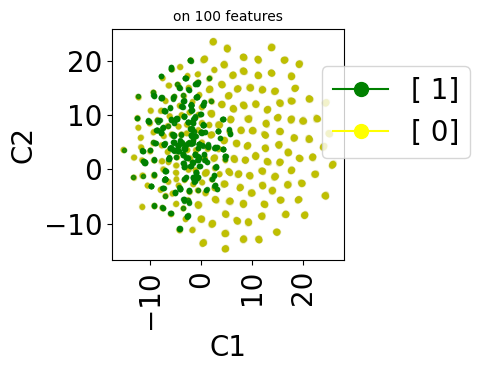

----------------------------------------------------------------------
* Rating matrix: 101 drugs x 101 diseases
Including 30 drugs and 101 diseases involved in at least one positive/negative rating
606 positive, 0 negative, 9595 unlabeled (including 0 unavailable) drug-disease ratings
Sparsity: 5.94 percent (on drugs/diseases with at least one known rating 20.00)
-----------------------------------
* Feature matrices:
#Drug features: 50	Total #Drugs: 101
Missing features: 0.00 percent
#Disease features: 50	Total #Disease: 101
Missing features: 0.00 percent
----------------------------------------------------------------------



,pi,c,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c,#Neg/#Pos
Value,0.3,0.2,1.0,0.059406,0.063158,0.29703,0.19802,0.2,0.0


In [3]:
from benchscofi.utils.prior_estimation import generate_Censoring_dataset

true_args_censoring = {"pi": 0.3, "c":0.2}
censoring_params = {}
censoring_params.update(true_args_censoring)
censoring_params.update(synthetic_params)

censoring_di, censoring_labels_mat = generate_Censoring_dataset(**censoring_params)
censoring_dt = stanscofi.datasets.Dataset(**censoring_di)
censoring_dt.visualize(withzeros=True, figsize=(3,3), dimred_args={"n_neighbors": 10})

censoring_dt.summary()

print_naive_estimators(censoring_dt, censoring_labels_mat, true_args_censoring)
## pi ~ #pos/#total in the true labels matrix which is OK
## c ~ (#pos/#total)/pi in the ratings matrix which is OK

#### 1.1.b  Case-Control setting

This setting allows negative samples to be accessible.

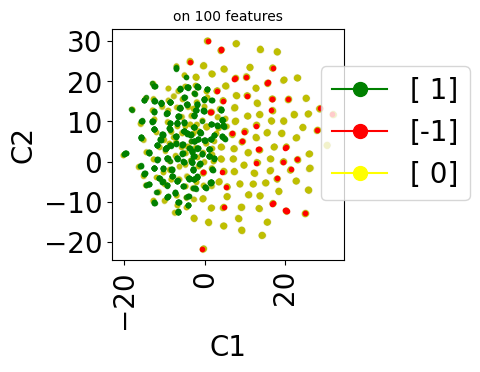

----------------------------------------------------------------------
* Rating matrix: 100 drugs x 100 diseases
Including 67 drugs and 100 diseases involved in at least one positive/negative rating
952 positive, 47 negative, 9001 unlabeled (including 0 unavailable) drug-disease ratings
Sparsity: 9.99 percent (on drugs/diseases with at least one known rating 14.91)
-----------------------------------
* Feature matrices:
#Drug features: 50	Total #Drugs: 100
Missing features: 0.00 percent
#Disease features: 50	Total #Disease: 100
Missing features: 0.00 percent
----------------------------------------------------------------------



,pi,imbalance,sparsity,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c,#Neg/#Pos
Value,0.3,0.05,0.1,0.952953,0.0999,0.105766,0.3,0.317333,0.317333,0.04937


In [4]:
from benchscofi.utils.prior_estimation import generate_CaseControl_dataset
reload(benchscofi.utils.prior_estimation)

true_args_casecontrol = {"pi": 0.3, "imbalance": 0.05, "sparsity": 0.1}
casecontrol_params = {}
casecontrol_params.update(true_args_casecontrol)
casecontrol_params.update(synthetic_params)

casecontrol_di, casecontrol_labels_mat = generate_CaseControl_dataset(**casecontrol_params)
casecontrol_di.update({"name": "casecontrol"})
casecontrol_dt = stanscofi.datasets.Dataset(**casecontrol_di)
casecontrol_dt.visualize(withzeros=True, figsize=(3,3), dimred_args={"n_neighbors": 10})

casecontrol_dt.summary()

print_naive_estimators(casecontrol_dt, casecontrol_labels_mat, true_args_casecontrol)
## pi ~ #pos/#total in the true labels matrix which is OK
## sparsity ~ #known/#total in the ratings matrix which is OK

### 1.2 Real-life drug repurposing dataset (unknown $\pi$)

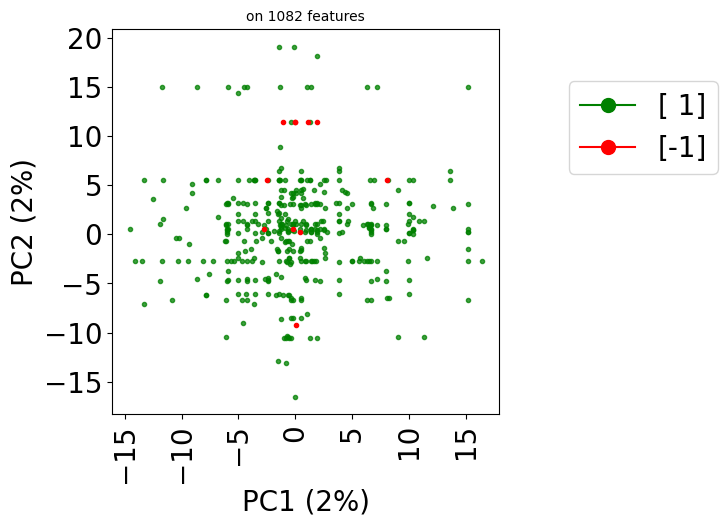

,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c,#Neg/#Pos
Value,0.973301,0.004451,0.004352,NaN,NaN,NaN,0.027431


In [5]:
dataset_name="TRANSCRIPT"
data_args = stanscofi.utils.load_dataset(dataset_name, dataset_folder)
data_args.update({"same_item_user_features": True}) ## because we use the TRANSCRIPT dataset
real_dataset = stanscofi.datasets.Dataset(**data_args)

real_dataset.visualize(withzeros=False)
print_naive_estimators(real_dataset, None, {})

## 2. Class prior estimation methods relying on a pretrained classifier

### 2.1 Train a classifier

We also generate a validation dataset which is produced in the same fashion as the training dataset. We first consider the synthetic Censoring dataset.

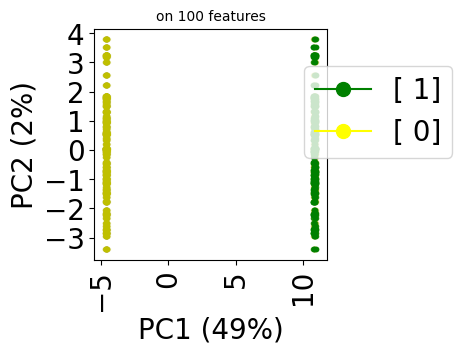

In [6]:
censoring_dt.visualize(withzeros=True, figsize=(3,3)) 
## PU methods should be OK, as unlabeled negatives are clearly different from (un)labeled positives

In [7]:
(traintest_folds, val_folds), _ = stanscofi.training_testing.random_simple_split(censoring_dt, 0.2,
                                                                                 metric="euclidean")
traintest_dataset = censoring_dt.subset(traintest_folds, subset_name="Train Test")
val_dataset = censoring_dt.subset(val_folds, subset_name="Validation")

print("Training/testing set")
traintest_dataset.summary()
print("Validation set")
val_dataset.summary()

Training/testing set
----------------------------------------------------------------------
* Rating matrix: 101 drugs x 101 diseases
Including 30 drugs and 99 diseases involved in at least one positive/negative rating
485 positive, 0 negative, 9716 unlabeled (including 2041 unavailable) drug-disease ratings
Sparsity: 4.75 percent (on drugs/diseases with at least one known rating 16.33)
-----------------------------------
* Feature matrices:
#Drug features: 50	Total #Drugs: 101
Missing features: 0.00 percent
#Disease features: 50	Total #Disease: 101
Missing features: 0.00 percent
----------------------------------------------------------------------

Validation set
----------------------------------------------------------------------
* Rating matrix: 101 drugs x 101 diseases
Including 30 drugs and 71 diseases involved in at least one positive/negative rating
121 positive, 0 negative, 10080 unlabeled (including 8160 unavailable) drug-disease ratings
Sparsity: 1.19 percent (on drugs/dis

(101,
 101,
 30,
 71,
 121,
 0,
 10080,
 8160,
 1.1861582197823743,
 5.68075117370892,
 50,
 0.0,
 50,
 0.0)

We train a Positive-Unlabeled classifier **[1]** on the training subset, and keep the validation subset to compute estimators of the class prior.

**[1]** Charles Elkan and Keith Noto. Learning classifiers from only positive and unlabeled data. In Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining, pages 213–220, 2008.

In [8]:
from benchscofi.PulearnWrapper import PulearnWrapper

results = stanscofi.training_testing.cv_training(PulearnWrapper, None, traintest_dataset, threshold=0, 
                    metric="AUC", k=5, beta=1, njobs=1, nsplits=5, random_state=rseed, cv_type="random", 
                    show_plots=False, verbose=True)

print("AUC on Test %f (Train %f)" % (
    np.max(results["test_metric"]), results["train_metric"][np.argmax(results["test_metric"])]
))

<validation.compute_metrics> Computed on #users=101, 3 ignored ( 3 perc)
<validation.compute_metrics> Computed on #users=101, 35 ignored (35 perc)
Crossvalidation step #1/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=101, 5 ignored ( 5 perc)
<validation.compute_metrics> Computed on #users=101, 36 ignored (36 perc)
Crossvalidation step #2/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=101, 3 ignored ( 3 perc)
<validation.compute_metrics> Computed on #users=101, 38 ignored (38 perc)
Crossvalidation step #3/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=101, 3 ignored ( 3 perc)
<validation.compute_metrics> Computed on #users=101, 37 ignored (37 perc)
Crossvalidation step #4/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=101, 2 ignored ( 2 perc)
<validation.compute_metrics> Computed on #users=101, 45 ignored (45 perc)
C

In [9]:
## Compute whole dataset AUC
from stanscofi.validation import AUC

aucs_whole = []
for i, (training_folds, testing_folds) in enumerate(results["cv_folds"]):
    m = results["models"][i]
    sf = traintest_dataset.subset(testing_folds)
    scores_sf = m.predict_proba(sf).toarray().ravel()
    y_sf = (sf.folds.toarray()*sf.ratings.toarray()).ravel()
    auc_whole = AUC(y_sf, scores_sf, 0, 0)
    aucs_whole.append(auc_whole)
aucs_whole

[0.9520216551983087,
 0.9466731558798802,
 0.9530940078850062,
 0.947374113344924,
 0.9584129180236877]

### 2.2 Estimators from the literature

**In the censoring setting**: Three estimators $e_1$, $e_2$ and $e_3$ of $c := \mathbb{P}(s=1 \mid y \neq 0)$ proposed by **[1]**. Given a trained classifier $\widehat{\theta}$, and a validation set $\mathcal{V} := \{ (v,y) \mid y \in \{-1,0,1\}, v \in \mathbb{R}^d \}$,
$$ e_1 := \frac{1}{|\{v \mid (v,+1) \in \mathcal{V}\}|}\sum_{(v,+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;;  e_2 := \frac{\sum_{(v',+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v'))_+}{\sum_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+}\;; e_3 := \max_{(v,y) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;. $$

If $f_{\widehat{\theta}}(v)=\mathbb{P}(s=1 | v)$ for any $v$, then $e_1=c$. It is assumed that $e_3 \leq c$. Authors recommend using $e_1$. But that approach requires having access to a supplementary validation dataset with labelled samples. One can retrieve an approximation of $\pi:=\mathbb{P}(s=1)$ by using $c\pi = \mathbb{P}(y=1) \approx \sum_{(v',+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v'))_+$
$$\hat{\pi}_i := \frac{e_i^{-1}}{|\mathcal{V}|}\sum_{(v,+1) \in \mathcal{V}} (f_{\widehat{\theta}}(v))_+\;.$$

**[1]** Charles Elkan and Keith Noto. Learning classifiers from only positive and unlabeled data. In Proceedings of the 14th ACM SIGKDD international conference on Knowledge discovery and data mining, pages 213–220, 2008.

In [10]:
trained_classifier = results["models"][np.argmax(aucs_whole)]

## test performance (to check for overfitting)
scores_test = m.predict_proba(val_dataset).toarray().ravel()
y_test = (val_dataset.folds.toarray()*val_dataset.ratings.toarray()).ravel()
print("AUC (full validation): %f" % AUC(y_test, scores_test, 0, 0))
## Obtained with predict_proba in pulearn, but do not belong to [0,1]...
print("min score=%.3f\tmean=%.3f\tmax=%.3f" % tuple([f(scores_test) for f in [np.min, np.mean, np.max]]))
print("Hold-out c = %f" % trained_classifier.estimator.c) ## c estimated by pulearn on hold-out data during training

AUC (full validation): 0.944936
min score=0.000	mean=0.148	max=7.583
Hold-out c = 0.078517


Assume that there are no unlabeled (all 0's are negative). Then we expect the estimators to determine that $c=1$, as no unlabeled are assumed.

In [11]:
y_test_ = y_test.copy()
pred_scores = y_test

[e1,pi1], [e2,pi2], [e3,pi3] = [
    prior_estimation.data_aided_estimation(pred_scores, y_test_, estimator_type=i) 
    for i in [1,2,3]
 ]

pd.DataFrame(
    [
        [e1, e2, e3, pi1, pi2, pi3],
        [true_args_censoring["c"]]*3+[true_args_censoring["pi"]]*3,
    ]
, index=["Estimated", "True"], columns=["e1", "e2", "e3", "pi1", "pi2", "pi3"])

,e1,e2,e3,pi1,pi2,pi3
Estimated,1.0,1.0,1.0,0.011862,0.011862,0.011862
True,0.2,0.2,0.2,0.300000,0.300000,0.300000


Using the trained PU classifier (use case): we would like $\pi$ and $c$ estimators to be as close as possible to their true values:

In [12]:
y_test_ = y_test.copy()
pred_scores = np.array([max(min(s,1),0) for s in scores_test])

[e1,pi1], [e2,pi2], [e3,pi3] = [
    prior_estimation.data_aided_estimation(pred_scores, y_test_, estimator_type=i) 
    for i in [1,2,3]
 ]

pd.DataFrame(
    [
        [e1, e2, e3, pi1, pi2, pi3],
        [true_args_censoring["c"]]*3+[true_args_censoring["pi"]]*3,
    ]
, index=["Estimated", "True"], columns=["e1", "e2", "e3", "pi1", "pi2", "pi3"])  

,e1,e2,e3,pi1,pi2,pi3
Estimated,0.786796,0.070389,1.0,0.011862,0.132586,0.009333
True,0.200000,0.200000,0.2,0.300000,0.300000,0.300000


Checking the performances of those estimators with an access to the true labels (*i*.*e*., no unlabeled data):

In [13]:
y_true = (censoring_labels_mat.values*val_folds.toarray()).ravel()
y_test_ = np.array([max(0,y) for y in y_true[y_true!=0]])
pred_scores = y_test_

[e1,pi1], [e2,pi2], [e3,pi3] = [
    prior_estimation.data_aided_estimation(pred_scores, y_test_, estimator_type=i) 
    for i in [1,2,3]
 ]

pd.DataFrame(
    [
        [e1, e2, e3, pi1, pi2, pi3],
        [true_args_censoring["c"]]*3+[true_args_censoring["pi"]]*3,
    ]
, index=["Estimated", "True"], columns=["e1", "e2", "e3", "pi1", "pi2", "pi3"])  

,e1,e2,e3,pi1,pi2,pi3
Estimated,1.0,1.0,1.0,0.287114,0.287114,0.287114
True,0.2,0.2,0.2,0.300000,0.300000,0.300000


### 2.3 Test on the real-life dataset

Let us test these estimators on the real-life dataset:

Dimension reduction


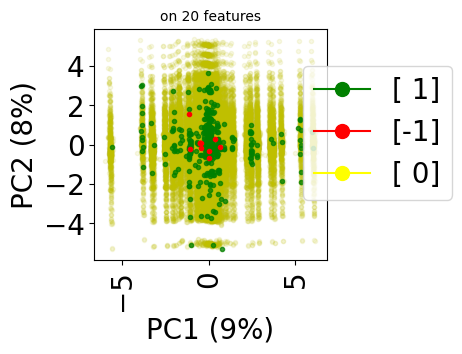

In [15]:
## Dimension reduction
subset=10 

## Select Top-k in terms of cross-sample variance
data_args_red = stanscofi.utils.load_dataset(dataset_name, dataset_folder)
var = np.concatenate((data_args_red["users"].values,data_args_red["items"]), axis=1).var(axis=1)
features = np.argsort(-var)[:subset]
data_args_red["users"] = data_args_red["users"].iloc[features,:]
data_args_red["items"] = data_args_red["items"].iloc[features,:]
data_args_red.update({"same_item_user_features": True})
red_real_dataset = stanscofi.datasets.Dataset(**data_args_red)
print("Dimension reduction")

red_real_dataset.visualize(withzeros=True, figsize=(3,3)) 
## That dataset seems kind of hard

In [16]:
(traintest_folds, val_folds), _ = stanscofi.training_testing.random_simple_split(red_real_dataset, 0.2,
                                                                                 metric="euclidean")
traintest_dataset = red_real_dataset.subset(traintest_folds, subset_name="Train Test")
val_dataset = red_real_dataset.subset(val_folds, subset_name="Validation")

print("Training/testing set")
traintest_dataset.summary()
print("Validation set")
val_dataset.summary()

results = stanscofi.training_testing.cv_training(PulearnWrapper, None, traintest_dataset, threshold=0, 
                    metric="AUC", k=5, beta=1, njobs=1, nsplits=5, random_state=rseed, cv_type="random", 
                    show_plots=False, verbose=True)

print("AUC on Test %f (Train %f)" % (
    np.max(results["test_metric"]), results["train_metric"][np.argmax(results["test_metric"])]
))

## Compute whole dataset AUC
aucs_whole = []
for i, (training_folds, testing_folds) in enumerate(results["cv_folds"]):
    m = results["models"][i]
    sf = traintest_dataset.subset(testing_folds)
    scores_sf = m.predict_proba(sf).toarray().ravel()
    y_sf = (sf.folds.toarray()*sf.ratings.toarray()).ravel()
    y_sf[y_sf<1] = 0
    auc_whole = AUC(y_sf, scores_sf, 0, 0)
    aucs_whole.append(auc_whole)
print(aucs_whole)

trained_classifier = results["models"][np.argmax(aucs_whole)]

## test performance (to check for overfitting)
scores_test = m.predict_proba(val_dataset).toarray().ravel()
y_test = (val_dataset.folds.toarray()*val_dataset.ratings.toarray()).ravel()
y_test[y_test<1] = 0
print("AUC (full validation): %f" % AUC(y_test, scores_test, 0, 0))
## Obtained with predict_proba in pulearn, but do not belong to [0,1]...
print("min score=%.3f\tmean=%.3f\tmax=%.3f" % tuple([f(scores_test) for f in [np.min, np.mean, np.max]]))
print("Hold-out c = %f" % trained_classifier.estimator.c) ## c estimated by pulearn on hold-out data during training

Training/testing set
----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 180 drugs and 101 diseases involved in at least one positive/negative rating
321 positive, 9 negative, 92233 unlabeled (including 18513 unavailable) drug-disease ratings
Sparsity: 0.36 percent (on drugs/diseases with at least one known rating 1.82)
-----------------------------------
* Feature matrices:
#Drug features: 10	Total #Drugs: 613
Missing features: 0.00 percent
#Disease features: 10	Total #Disease: 151
Missing features: 0.00 percent
----------------------------------------------------------------------

Validation set
----------------------------------------------------------------------
* Rating matrix: 613 drugs x 151 diseases
Including 63 drugs and 58 diseases involved in at least one positive/negative rating
80 positive, 2 negative, 92481 unlabeled (including 74050 unavailable) drug-disease ratings
Sparsity: 0.09 percent (on drugs/

In [17]:
## use case (we do not have access to the true labels here...)
y_test_ = y_test.copy()
pred_scores = np.array([max(min(s,1),0) for s in scores_test])

[e1,pi1], [e2,pi2], [e3,pi3] = [
    prior_estimation.data_aided_estimation(pred_scores, y_test_, estimator_type=i) 
    for i in [1,2,3]
 ]

pd.DataFrame(
    [
        [e1, e2, e3, pi1, pi2, pi3]
    ]
, index=["Estimated"], columns=["e1", "e2", "e3", "pi1", "pi2", "pi3"])  

,e1,e2,e3,pi1,pi2,pi3
Estimated,0.890351,0.00437,1.0,0.000864,0.176107,0.00077


Given the results on the synthetic dataset, perhaps we should not trust too much those values.

## 3. Class prior estimation methods with Bayes regret approach

### 3.1 Definition

**In the case-control setting:**  **[1, Theorem $4$]** shows that if the supports for $p_+$ and $p_-$ are different
$$\hat{\pi} = -\lim_{\substack{\alpha \rightarrow 1\\ \alpha < 1}}\frac{\partial}{\partial \alpha}\inf_{\theta \in \Theta} \left\{  \underbrace{\mathcal{R}_\text{0-1}(\theta)}_\text{Bayes regret} \mid \mathbb{E}_{v \sim p_-}\ell_{0-1}(C_\theta(v),-1) \leq \alpha \right\}(\alpha)\;.$$

The issue is that the equation shown above can't be computed exactly in practice. As mentioned in **[2]**, a possible approach to approximate $\hat{\pi}$ is to regress a specific model (given in **[2]**) on the points of the corresponding ROC curve, and use the fitted model to extract the slope at the right-hand side of the curve, which is $\hat{\pi}$.

**[1]** Scott, Clayton, and Gilles Blanchard. "Novelty detection: Unlabeled data definitely help." Artificial intelligence and statistics. PMLR, 2009.

**[2]** Sanderson, Tyler, and Clayton Scott. "Class proportion estimation with application to multiclass anomaly rejection." Artificial Intelligence and Statistics. PMLR, 2014.

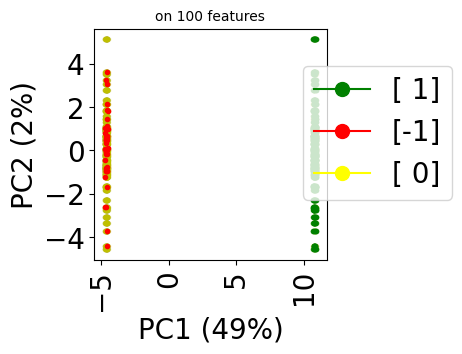

In [18]:
casecontrol_dt.visualize(withzeros=True, figsize=(3,3)) 
## PU methods should be OK, as unlabeled negatives are clearly different from (un)labeled positives

In [19]:
(traintest_folds, val_folds), _ = stanscofi.training_testing.random_simple_split(casecontrol_dt, 0.2,
                                                                                 metric="euclidean")
traintest_dataset = casecontrol_dt.subset(traintest_folds, subset_name="Train Test")
val_dataset = casecontrol_dt.subset(val_folds, subset_name="Validation")

print("Training/testing set")
traintest_dataset.summary()
print("Validation set")
val_dataset.summary()

results = stanscofi.training_testing.cv_training(PulearnWrapper, None, traintest_dataset, threshold=0, 
                    metric="AUC", k=5, beta=1, njobs=1, nsplits=5, random_state=rseed, cv_type="random", 
                    show_plots=False, verbose=True)

## Compute whole dataset AUC
aucs_whole = []
for i, (training_folds, testing_folds) in enumerate(results["cv_folds"]):
    m = results["models"][i]
    sf = traintest_dataset.subset(testing_folds)
    scores_sf = m.predict_proba(sf).toarray().ravel()
    y_sf = (sf.folds.toarray()*sf.ratings.toarray()).ravel()
    y_sf[y_sf<1] = 0
    auc_whole = AUC(y_sf, scores_sf, 0, 0)
    aucs_whole.append(auc_whole)
print(aucs_whole)

trained_classifier = results["models"][np.argmax(aucs_whole)]

## test performance (to check for overfitting)
scores_test = m.predict_proba(val_dataset).toarray().ravel()
y_test = (val_dataset.folds.toarray()*val_dataset.ratings.toarray()).ravel()
y_test[y_test<1] = 0
print("AUC (full validation): %f" % AUC(y_test, scores_test, 0, 0))
## Obtained with predict_proba in pulearn, but do not belong to [0,1]...
print("min score=%.3f\tmean=%.3f\tmax=%.3f" % tuple([f(scores_test) for f in [np.min, np.mean, np.max]]))
print("Hold-out c = %f" % trained_classifier.estimator.c) ## c estimated by pulearn on hold-out data during training

Training/testing set
----------------------------------------------------------------------
* Rating matrix: 100 drugs x 100 diseases
Including 61 drugs and 100 diseases involved in at least one positive/negative rating
762 positive, 37 negative, 9201 unlabeled (including 2000 unavailable) drug-disease ratings
Sparsity: 7.99 percent (on drugs/diseases with at least one known rating 13.10)
-----------------------------------
* Feature matrices:
#Drug features: 50	Total #Drugs: 100
Missing features: 0.00 percent
#Disease features: 50	Total #Disease: 100
Missing features: 0.00 percent
----------------------------------------------------------------------

Validation set
----------------------------------------------------------------------
* Rating matrix: 100 drugs x 100 diseases
Including 39 drugs and 91 diseases involved in at least one positive/negative rating
190 positive, 10 negative, 9800 unlabeled (including 8000 unavailable) drug-disease ratings
Sparsity: 2.00 percent (on drugs/d

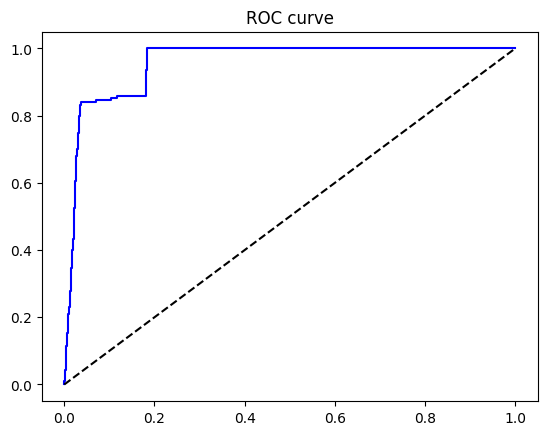

Optimization terminated successfully.
         Current function value: 170.291473
         Iterations: 24
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 170.291473
         Iterations: 24
         Function evaluations: 119


,pi*1,pi*2
Estimated,1.0,1.0
True,0.3,0.3


In [20]:
pi_star1, pi_star2 = [
    prior_estimation.roc_aided_estimation(scores_test, y_test, regression_type=i, verbose=True,
                                          show_plot=(i<2)) for i in [1,2]
]

pd.DataFrame(
    [
        [pi_star1, pi_star2],
        [true_args_censoring["pi"]]*2,
    ]
, index=["Estimated", "True"], columns=["pi*1", "pi*2"])

[0.990768881984408, 0.9913628689795048, 0.9938651922714428, 0.9905748944638959, 0.9886602588510526]
Test 1, pi=0.100000, pi*1=1.000000 pi*2=1.000000
[0.9926170234654121, 0.9902320829756519, 0.9914211752885194, 0.9914961012658229, 0.9896822609217758]
Test 2, pi=0.200000, pi*1=1.000000 pi*2=1.000000
[0.9718250299285989, 0.9749115718864643, 0.9740573254453266, 0.9708049189790072, 0.9743201932532387]
Test 3, pi=0.300000, pi*1=1.000000 pi*2=1.000000
[0.9901050646709482, 0.9907097132123492, 0.9897842442498844, 0.9911163110080702, 0.9876039879700543]
Test 4, pi=0.400000, pi*1=1.000000 pi*2=1.000000
[0.991785233671723, 0.9944166911548633, 0.9920462574514988, 0.9906901436956081, 0.9893250581598905]
Test 5, pi=0.500000, pi*1=1.000000 pi*2=1.000000
[0.9914282482550757, 0.9895616740395484, 0.9917303846404522, 0.9909153973559391, 0.9910133132412149]
Test 6, pi=0.600000, pi*1=1.000000 pi*2=1.000000
[0.9873374462727986, 0.9883016386101898, 0.9892338383046552, 0.9899182711580077, 0.9889427285436183]
T

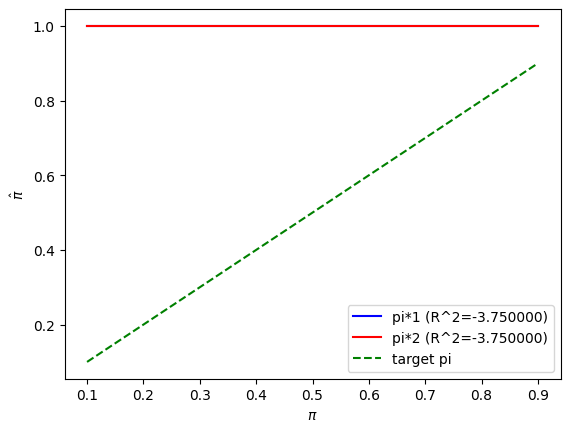

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

## One could also have more precise estimates by iterating on several random seeds (here we always consider rseed)
def test_estimator(pi_true):
    pi_hats, pi_hats2 = [], []
    for i, pi_t in enumerate(pi_true):
        casecontrol_params_pi = {}
        casecontrol_params_pi.update(true_args_casecontrol)
        casecontrol_params_pi.update(synthetic_params)
        casecontrol_params_pi.update({'pi': pi_t})
        data_args_pi, labels = generate_CaseControl_dataset(**casecontrol_params_pi)
        casecontrol_dt_pi = stanscofi.datasets.Dataset(**data_args_pi)
        #print(print_naive_estimators(casecontrol_dt_pi, labels, casecontrol_params_pi))
        (traintest_folds_pi, val_folds_pi), _ = stanscofi.training_testing.random_simple_split(casecontrol_dt_pi, 
                                                                        0.2, metric="euclidean")
        traintest_dataset_pi = casecontrol_dt.subset(traintest_folds_pi, subset_name="Train Test")
        val_dataset_pi = casecontrol_dt.subset(val_folds_pi, subset_name="Validation")
        results_pi = stanscofi.training_testing.cv_training(PulearnWrapper, None, traintest_dataset_pi, 
            threshold=0, metric="AUC", k=5, beta=1, njobs=1, nsplits=5, random_state=rseed, cv_type="random", 
            show_plots=False, verbose=False)
        ## Compute whole dataset AUC
        aucs_whole_pi = []
        for iff, (training_folds, testing_folds) in enumerate(results_pi["cv_folds"]):
            m = results["models"][iff]
            sf = traintest_dataset.subset(testing_folds)
            scores_sf = m.predict_proba(sf).toarray().ravel()
            y_sf = (sf.folds.toarray()*sf.ratings.toarray()).ravel()
            y_sf[y_sf<1] = 0
            auc_whole = AUC(y_sf, scores_sf, 0, 0)
            aucs_whole_pi.append(auc_whole)
        print(aucs_whole_pi)
        trained_classifier_pi = results_pi["models"][np.argmax(aucs_whole_pi)]
        pred_scores_pi = m.predict_proba(val_dataset_pi).toarray().ravel()
        y_test_pi = (val_dataset_pi.folds.toarray()*val_dataset_pi.ratings.toarray()).ravel()
        y_test_pi[y_test_pi<1] = 0
        pi_hat = prior_estimation.roc_aided_estimation(pred_scores_pi, y_test_pi, regression_type=1)
        pi_hat2 = prior_estimation.roc_aided_estimation(pred_scores_pi, y_test_pi, regression_type=2)
        pi_hats.append(pi_hat)
        pi_hats2.append(pi_hat2)
        print("Test %d, pi=%f, pi*1=%f pi*2=%f" % (i+1, pi_t, pi_hat, pi_hat2))
    R = r2_score(pi_true, pi_hats)
    plt.plot(pi_true, pi_hats, "b-", label="pi*1 (R^2=%f)" % R)
    R2 = r2_score(pi_true, pi_hats2)
    plt.plot(pi_true, pi_hats2, "r-", label="pi*2 (R^2=%f)" % R2)
    plt.plot(pi_true, pi_true, "g--", label="target pi")
    plt.xlabel(r"$\pi$")
    plt.ylabel(r"$\hat{\pi}$")
    plt.legend()
    plt.show()
    
test_estimator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

Those bad results might be due to the shape of the ROC curve which does not allow to get a nonzero slope on its right-hand side.

### 3.2 Test on the real-life dataset

Let us test these estimators on the real-life dataset:

In [22]:
## Dimension reduction
subset=10 

## Select Top-k in terms of cross-sample variance
data_args_red = stanscofi.utils.load_dataset(dataset_name, dataset_folder)
var = np.concatenate((data_args_red["users"].values,data_args_red["items"]), axis=1).var(axis=1)
features = np.argsort(-var)[:subset]
data_args_red["users"] = data_args_red["users"].iloc[features,:]
data_args_red["items"] = data_args_red["items"].iloc[features,:]
data_args_red.update({"same_item_user_features": True})
red_real_dataset = stanscofi.datasets.Dataset(**data_args_red)
print("Dimension reduction")

(traintest_folds, val_folds), _ = stanscofi.training_testing.random_simple_split(red_real_dataset, 0.2,
                                                                                 metric="euclidean")
traintest_dataset = red_real_dataset.subset(traintest_folds, subset_name="Train Test")
val_dataset = red_real_dataset.subset(val_folds, subset_name="Validation")

results = stanscofi.training_testing.cv_training(PulearnWrapper, None, traintest_dataset, threshold=0, 
                    metric="AUC", k=5, beta=1, njobs=1, nsplits=5, random_state=rseed, cv_type="random", 
                    show_plots=False, verbose=True)

print("AUC on Test %f (Train %f)" % (
    np.max(results["test_metric"]), results["train_metric"][np.argmax(results["test_metric"])]
))

## Compute whole dataset AUC
aucs_whole = []
for i, (training_folds, testing_folds) in enumerate(results["cv_folds"]):
    m = results["models"][i]
    sf = traintest_dataset.subset(testing_folds)
    scores_sf = m.predict_proba(sf).toarray().ravel()
    y_sf = (sf.folds.toarray()*sf.ratings.toarray()).ravel()
    y_sf[y_sf<1] = 0
    auc_whole = AUC(y_sf, scores_sf, 0, 0)
    aucs_whole.append(auc_whole)
print(aucs_whole)

trained_classifier = results["models"][np.argmax(aucs_whole)]

## test performance (to check for overfitting)
scores_test = m.predict_proba(val_dataset).toarray().ravel()
y_test = (val_dataset.folds.toarray()*val_dataset.ratings.toarray()).ravel()
y_test[y_test<1] = 0
print("AUC (full validation): %f" % AUC(y_test, scores_test, 0, 0))
## Obtained with predict_proba in pulearn, but do not belong to [0,1]...
print("min score=%.3f\tmean=%.3f\tmax=%.3f" % tuple([f(scores_test) for f in [np.min, np.mean, np.max]]))
print("Hold-out c = %f" % trained_classifier.estimator.c) ## c estimated by pulearn on hold-out data during training

Dimension reduction
<validation.compute_metrics> Computed on #users=151, 65 ignored (43 perc)
<validation.compute_metrics> Computed on #users=151, 110 ignored (73 perc)
Crossvalidation step #1/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=151, 69 ignored (46 perc)
<validation.compute_metrics> Computed on #users=151, 108 ignored (72 perc)
Crossvalidation step #2/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=151, 64 ignored (42 perc)
<validation.compute_metrics> Computed on #users=151, 111 ignored (74 perc)
Crossvalidation step #3/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=151, 64 ignored (42 perc)
<validation.compute_metrics> Computed on #users=151, 113 ignored (75 perc)
Crossvalidation step #4/5 (train AUC 0.500000, test AUC 0.500000)
<validation.compute_metrics> Computed on #users=151, 60 ignored (40 perc)
<validation.compute_metrics> Computed on #user

Checking out the estimators for $\pi$

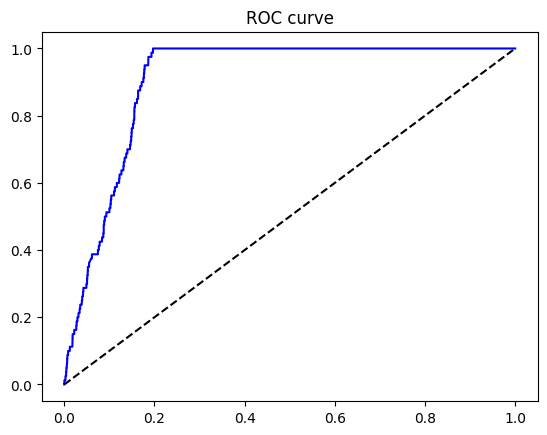

Optimization terminated successfully.
         Current function value: 142.605260
         Iterations: 24
         Function evaluations: 95
Optimization terminated successfully.
         Current function value: 142.605260
         Iterations: 24
         Function evaluations: 119


,pi*1,pi*2
Estimated,1.0,1.0


In [23]:
pi_star1, pi_star2 = [
    prior_estimation.roc_aided_estimation(scores_test, y_test, regression_type=i, verbose=True,
                                          show_plot=(i<2)) for i in [1,2]
]

pd.DataFrame(
    [
        [pi_star1, pi_star2]
    ]
, index=["Estimated"], columns=["pi*1", "pi*2"])

## 4. Class prior estimation methods through penalized divergences

Contrary to the last two approaches, these methods do not use a pretrained classifier.

### 4.1 Definition 

$\lambda$ and $\sigma$ are regularization parameters, and $p$ (resp., $u$) is the total number of positive (resp., unlabeled) samples).

Using L1-distance penalized divergence **[1]** amounts to minimizing the following scalar function:

$$\hat{\pi}_\text{L1} := \arg\min_{\pi \in (0,1)} \frac{1}{\lambda}\sum_{l \leq p+u} ((\beta_l(\pi))_+)^2-\pi+1 \text{ and } \beta_l(\pi) := \frac{\pi}{u}\sum_{i \leq u} \mathcal{N}(x_l, \sigma^2 \text{Id})(x_i)-\frac{1}{p}\sum_{j \leq p} \mathcal{N}(x_l, \sigma^2 \text{Id})(x_j)\;.$$

**[1]** Christoffel, Marthinus, Gang Niu, and Masashi Sugiyama. "Class-prior estimation for learning from positive and unlabeled data." Asian Conference on Machine Learning. PMLR, 2016.

Using the Pearson penalized divergence **[2]** amounts to minimizing the following scalar function:

$$\hat{\pi}_\text{Pearson} := \arg\min_{\pi \in (0,1)} -\frac{1}{2}\left[^{1-\pi}_{\pi}\right] H^\top(G + \lambda R)^{-1}G(G+\lambda R)^{-1}H\left[^{1-\pi}_{\pi}\right]^\top+\left[^{1-\pi}_{\pi}\right] H^\top (G+\lambda R)^{-1} H\left[^{1-\pi}_{\pi}\right]^\top-\frac{1}{2} $$

$\text{ and } H := \left[\frac{1}{u}\sum_{j \leq u}\left(\mathcal{N}(x_l, \sigma^2 \text{Id})(x_j)\right)_{0 \leq l \leq u+p}, \frac{1}{p}\sum_{i \leq p}\left(\mathcal{N}(x_l, \sigma^2 \text{Id})(x_i)\right)_{0 \leq l \leq u+p} \right] \in \mathbb{R}^{(u+p+1) \times 2} \;, R := \left[^{0}_{(0)_{(u+p) \times 1}} ,^{(0)_{1 \times (u+p)}}_{Id_{(u+p) \times (u+p)}}\right] \in \mathbb{R}^{(u+p+1) \times (u+p+1)} \;,$

$G:=\frac{1}{u+p} \sum_{i \leq u+p} \left(\mathcal{N}(x_l, \sigma^2 \text{Id})(x_i)\right)_{0 \leq l \leq u+p}^\top\left(\mathcal{N}(x_l, \sigma^2 \text{Id})(x_i)\right)_{0 \leq l \leq u+p} \in \mathbb{R}^{(u+p+1) \times (u+p+1)}$ where $\forall x, \mathcal{N}(x_0, \sigma^2 \text{Id})(x)=1$.

**[2]** Du Plessis, Marthinus Christoffel, and Masashi Sugiyama. "Semi-supervised learning of class balance under class-prior change by distribution matching." Neural Networks 50 (2014): 110-119.

Test 1, pi=0.100000, pi(L1)=0.007653 pi(pearson)=0.066683
Test 2, pi=0.200000, pi(L1)=0.093750 pi(pearson)=0.200012
Test 3, pi=0.300000, pi(L1)=0.198347 pi(pearson)=0.266676
Test 4, pi=0.400000, pi(L1)=0.666667 pi(pearson)=0.400004
Test 5, pi=0.500000, pi(L1)=0.999994 pi(pearson)=0.466668
Test 6, pi=0.600000, pi(L1)=0.999994 pi(pearson)=0.599996
Test 7, pi=0.700000, pi(L1)=0.999994 pi(pearson)=0.733324
Test 8, pi=0.800000, pi(L1)=0.999994 pi(pearson)=0.799988
Test 9, pi=0.900000, pi(L1)=0.999994 pi(pearson)=0.933317


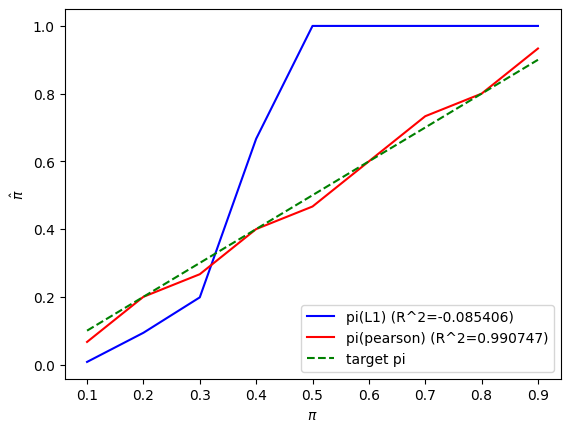

In [24]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from benchscofi.utils import prior_estimation
reload(prior_estimation)

## One could also have more precise estimates by iterating on several random seeds (here we always consider rseed)
def test_estimator(pi_true):
    pi_hats, pi_hats2 = [], []
    for i, pi_t in enumerate(pi_true):
        true_args_casecontrol = {"pi": pi_t, "imbalance": 0.0001, "sparsity": 0.9999} 
        casecontrol_params = {}
        casecontrol_params.update(true_args_casecontrol)
        casecontrol_params.update(synthetic_params)
        casecontrol_params.update({"N": 250})
        casecontrol_di, casecontrol_labels_mat = generate_CaseControl_dataset(**casecontrol_params)
        casecontrol_dt_pi = stanscofi.datasets.Dataset(**casecontrol_di)
        #print(
        #    "Naive pi=%f" % float(
        #    print_naive_estimators(casecontrol_dt_pi,casecontrol_labels_mat,casecontrol_di)["#Pos/#Known(true)~pi"]
        #    )
        #)
        X, y, _, _ = stanscofi.preprocessing.meanimputation_standardize(casecontrol_dt_pi)
        pi_hat = prior_estimation.divergence_aided_estimation(X, y, lmb=1., sigma=.01, divergence_type="L1-distance") 
        pi_hat2 = prior_estimation.divergence_aided_estimation(X, y, lmb=1., sigma=.01, divergence_type="Pearson") 
        pi_hats.append(pi_hat)
        pi_hats2.append(pi_hat2)
        print("Test %d, pi=%f, pi(L1)=%f pi(pearson)=%f" % (i+1, pi_t, pi_hat, pi_hat2))
    R = r2_score(pi_true, pi_hats)
    plt.plot(pi_true, pi_hats, "b-", label="pi(L1) (R^2=%f)" % R)
    R2 = r2_score(pi_true, pi_hats2)
    plt.plot(pi_true, pi_hats2, "r-", label="pi(pearson) (R^2=%f)" % R2)
    plt.plot(pi_true, pi_true, "g--", label="target pi")
    plt.xlabel(r"$\pi$")
    plt.ylabel(r"$\hat{\pi}$")
    plt.legend()
    plt.show()
    
test_estimator([0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])

These estimators seem the most promising for our problem.

### 4.2 Test on the real-life dataset

Estimation on the real-life dataset **TRANSCRIPT**:

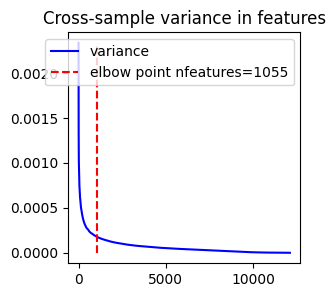

23 #known points


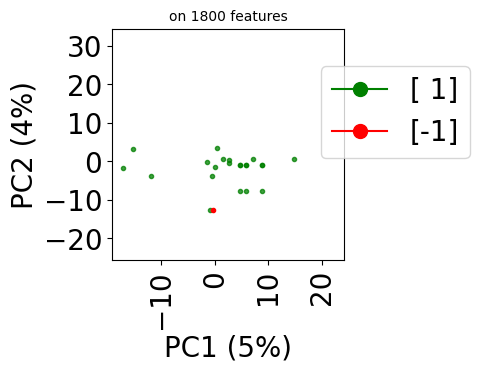

,#Pos/#Known,#Known/#Total~sparsity,#Pos/#Unk,#Pos/#Known(true)~pi,#Pos/(#Total*pi)~c,(#Pos/#Total)/(#Pos/#Known(true))~c,#Neg/#Pos
Value,0.956522,0.025556,0.025086,NaN,NaN,NaN,0.045455


In [25]:
dataset_name="TRANSCRIPT"
data_args = stanscofi.utils.load_dataset(dataset_name, dataset_folder)

## Dimension reduction
var = np.concatenate((data_args["users"].values,data_args["items"].values), axis=1).var(axis=1)
argval = np.argsort(-var)
var = [var[a] for a in argval]

import matplotlib.pyplot as plt
plt.figure(figsize=(3,3))
plt.plot(range(len(argval)), var, "b-", label="variance")
window=range(max(0,1000),len(argval)-1)
cons_var = window[np.argmax([var[i]-var[i+1] for i in window])]
plt.plot([cons_var]*2, [np.min(var), np.max(var)], "r--", label="elbow point nfeatures=%d" % cons_var)
plt.title("Cross-sample variance in features")
plt.legend()
plt.show()

subset=cons_var

features = argval[:subset]
data_args["users"] = data_args["users"].iloc[features,:]
data_args["items"] = data_args["items"].iloc[features,:]

## Datapoints reduction

restr=30

items_sum = np.abs(data_args["ratings"].values).sum(axis=1) ## maximize the numbre of informative points
items_ls = data_args["ratings"].iloc[np.argsort(-items_sum),:].iloc[items_sum>0,:].index
users_sum = np.abs(data_args["ratings"].values).sum(axis=0)
users_ls = data_args["ratings"].iloc[np.argsort(-users_sum),:].iloc[:,users_sum>0].columns

#items_ls = data_args["ratings_mat"].iloc[items_sum>0,:].index
#users_ls = data_args["ratings_mat"].iloc[:,users_sum>0].columns

items_ls = items_ls[:restr]
users_ls = users_ls[:restr]
data_args["ratings"] = data_args["ratings"][users_ls].loc[items_ls]
data_args["users"] = data_args["users"][users_ls]
data_args["items"] = data_args["items"][items_ls]
real_dataset = stanscofi.datasets.Dataset(**data_args)

print("%d #known points" % (real_dataset.ratings.toarray()!=0).sum())

real_dataset.visualize(withzeros=False, figsize=(3,3))
print_naive_estimators(real_dataset, None, {})

In [26]:
X, y, _, _ = stanscofi.preprocessing.meanimputation_standardize(real_dataset) ##lambda ~ sparsity
pi_L1 = prior_estimation.divergence_aided_estimation(X, y, lmb=0.026, sigma=.01, divergence_type="L1-distance") 
pi_Pearson = prior_estimation.divergence_aided_estimation(X, y, lmb=0.026, sigma=.01, divergence_type="Pearson")
(pi_L1, pi_Pearson)

(0.0006360126815448258, 0.019894049344071615)

We would probably on the safe side if we assumed that in this dataset, $\pi \leq 0.02$.